# 3.1 Analytical Method

In [1]:
from utils.analytical.utils import *

This chapter presents a detailed methodology for estimating external joint torques on a LARA8 equipped with Harmonic Drive Transmissions (HDTs) and dual encoders. Starting from measuring the transmission error using the dual encoders, the approach focuses on modelling and compensating for the transmission errors caused by known torques. The primary hypothesis is that any remaining deformation can be attributed to external forces by accounting for these known torques, thereby isolating the external joint torque.

To streamline the study's complexity and achieve precise torque estimations, the research was concentrated on a single robot joint. Focusing on one joint allows for a more controlled and detailed analysis of the torque components, reducing the variables that could affect the accuracy of the results. Joint 3 was chosen due to the significant torque loads it typically experiences and the wider range of motion. This joint's configuration and operation make it particularly suitable for studying the effects of various torque components, both internal and external.


## 3.1.1 Experimental Setup and Data Collection

The robot was mounted horizontally, with its base attached to a vertical plane, positioning Axis 3 parallel to the gravity vector and allowing it to rotate in a Horizontal plane. This orientation effectively eliminated gravitational torque components, enabling a focused study on internal torques such as frictional and position-dependent torques. In this setup, Joint 3 was rotated from one limit to the other while all other joints were kept at  0 degrees, covering the full range of motion. This was done at various velocities (elaborate on range of velocities).

Data collection included recording joint velocity, joint angle, torque feedforward, load-side encoder counts, and motor-side encoder counts at every 2 ms interval. This high-resolution data sampling ensured that detailed and accurate information was captured.

In [2]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("analytical_dataset")
data = preprocess()

downloading data:   0%|          | 0/170923 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


preprocessing:   0%|          | 0/44 [00:00<?, ?it/s]

As discussed in section 2, transmission error 𝜃𝑒 can be represented by the following equation.
$$
\theta_e = \frac{\theta_m}{N }- \theta_l
$$
where 𝜃𝑚 corresponds to the input motor shaft position, N is the gear ratio
and 𝜃𝑙 pertains to the output load shaft position. This equation captures the difference between the scaled motor position and the actual load position, effectively measuring the torsional deformation within the Harmonic Drive Transmission.

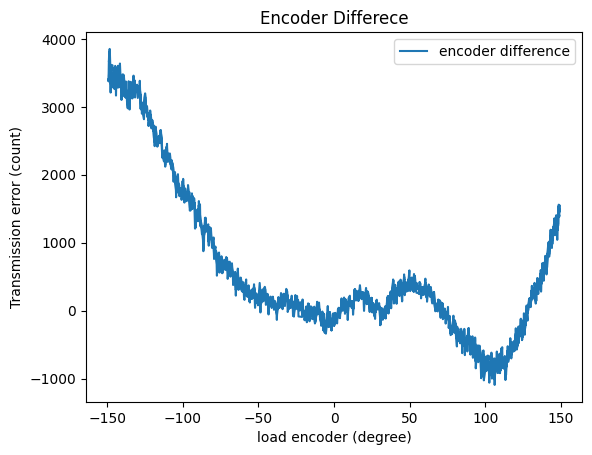

In [3]:
# A random sample from the collected data is selected, and its Transmission error is visualized
import random 

sample = random.choice(list(data.keys()))

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].encoder_motorinc_3/gear_ratio - data[sample].encoder_loadinc_3,label ='encoder difference')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder (degree)')
plt.legend(loc='upper right')
plt.title("Encoder Differece")
plt.show()

The encoder data received is notably affected by significant noise, making it unsuitable for training the model. To rectify this, a low-pass filter with a cut-off frequency set at 50 Hz is applied. This filter effectively reduces the noise while preserving the integrity of the original data.

Text(0.5, 1.0, 'Transmission Error after applying low pass filter')

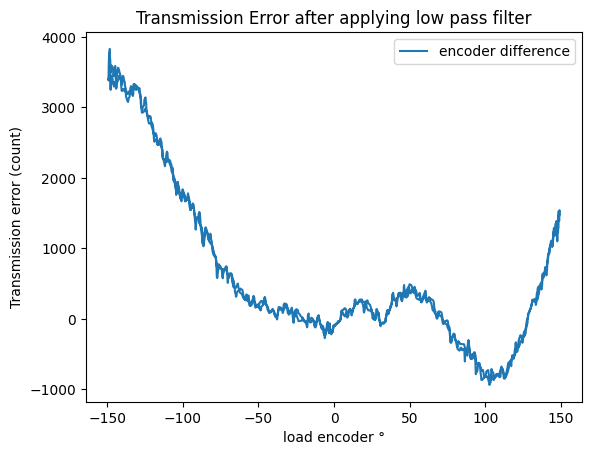

In [4]:
#apply low pass filter
for key in data:
    data[key]= filter(data[key],50)

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].filtered_motor_enc/gear_ratio - data[sample].filtered_load_enc,label ='encoder difference')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder °')
plt.legend(loc='upper right')
plt.title("Transmission Error after applying low pass filter")

## 3.1.2 Position Based Error

To model the characteristic position-based error, often referred to as the "footprint," we begin by understanding the nature of the transmission error in harmonic drive systems. One of the torques causing the transmission error arises due to factors such as gear eccentricity and tooth profile errors of the harmonic drive transmission and is characteristic to each HDT.

This component of the transmission error is periodic with respect to the joint position. Following the works [], this periodic nature of the transmission error is effectively captured using a Fourier series model. This model decomposes the error into sine and cosine terms, representing different frequency components associated with the gear's rotational position. The general form of the Fourier series used to model the transmission error is given by:
$$
θe(θm)=A0+∑n=1∞[Ancos⁡(nωθm)+Bnsin⁡(nωθm)]θe​(θm​)=A0​+∑n=1∞​[An​cos(nωθm​)+Bn​sin(nωθm​)]
$$
Here, A0A0​ represents the static offset, which can be influenced by factors such as the direction of motion and any consistent bias in the system. The coefficients AnAn​ and BnBn​ correspond to the amplitude of the cosine and sine components at each harmonic frequency nωnω. These coefficients are determined based on the system's empirical data, capturing the transmission error's specific characteristics for a given harmonic drive.

The slowest speed among the collected data sets was selected for further analysis. This choice minimized the effects of dynamic forces such as Coriolis and centrifugal terms. It ensured that the torques associated with accelerating and decelerating the joint to this small velocity were negligible and their duration minimal. This focus allowed for isolating primarily frictional and position-dependent torques, providing the clearest data for accurately modelling the characteristic position-based error in the harmonic drive system.

RMS value residual error: 0.007282916530979559
RMS value actual error: 0.03723588441508763
The Model has reduced the error


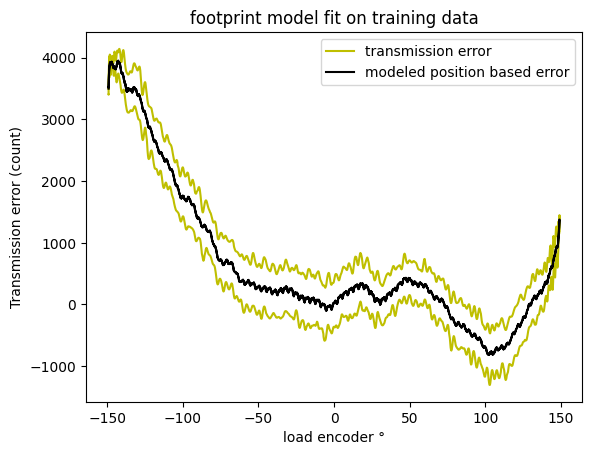

In [5]:
#learn characteristic footprint error from the slowest data 
footprint_coeff = model_footprint(data["0.97"])
np.save("utils/analytical/footprint_coeff.npy",footprint_coeff)

for key in data:
    data[key]['modeled_footprint'] = data[key].apply(lambda row: footprint_error(footprint_coeff,row["filtered_motor_enc"], row["filtered_load_enc"]), axis=1)


plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg, (data["0.97"].filtered_motor_enc/gear_ratio - data["0.97"].filtered_load_enc) ,'y',label = 'transmission error')
plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg,data["0.97"].modeled_footprint/count_to_deg,'black',label = 'modeled position based error')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on training data")
plt.show()

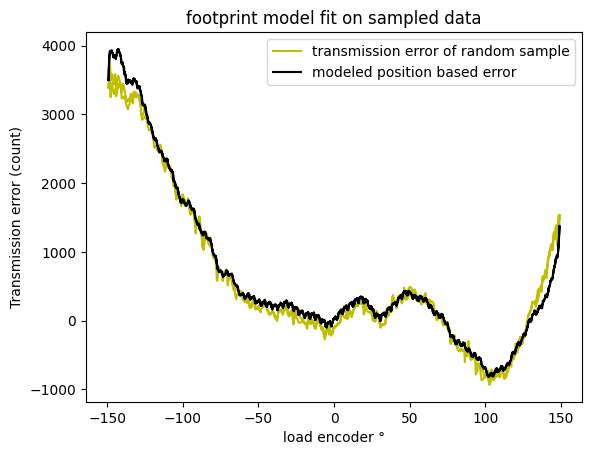

In [6]:
plt.plot(data[sample].encoder_loadinc_3*count_to_deg, (data[sample].filtered_motor_enc/gear_ratio - data[sample].filtered_load_enc) ,'y',label = 'transmission error of random sample')
plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].modeled_footprint/count_to_deg,'black',label = 'modeled position based error')
plt.ylabel('Transmission error (count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on sampled data")
plt.show()

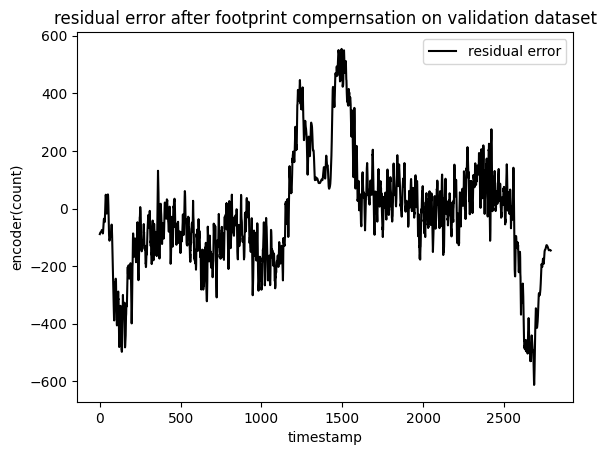

In [7]:
#calculate residuals by compensating for footprint
for key in data:
    data[key]['residual_error'] = data[key].filtered_motor_enc/gear_ratio - data[key].filtered_load_enc - data[key].modeled_footprint/count_to_deg #count

plt.plot(data["0.27"].residual_error,'black',label = 'residual error')
plt.ylabel('encoder(count)')
plt.xlabel('timestamp')
plt.legend()
plt.title("residual error after footprint compernsation on validation dataset")
plt.show()
plt.close()

## 3.1.3 Feed Forward Torque

To accurately estimate the external joint torques in the robotic system, it is essential to account for various known torque components, including inertial, damping, and Coriolis forces and Friction. These components were combined into the robot's dynamic calculations and provided to the controller as torque feedforward, a component readily available in the recorded data. The inertial torque, which depends on the joint's acceleration, the damping torque, proportional to the joint's velocity, and the Coriolis forces, influenced by the interaction between different axes and their velocities, were all integral to this feedforward calculation.The torque feed forward also contains the friction component which is composed of friction in the motor and friction couplings, since some part of the friction torque is already lost in the motor, only a part of this friction needs to be compensated form the encoder difference, hence the entire friction is removed from the torque feed forward and a separate friction model is fit and compensated separately in the next section. By using the torque feedforward data, these known torque components were effectively compensated for, allowing the residual torque to primarily reflect the external forces acting on the system. This approach ensured that the dynamic effects inherent to the robot's motion were accurately modeled and subtracted, providing a clear path to isolate and estimate the external joint torques accurately.

In [8]:
#compensat for dynamics(remove friction component in dynamic)
for key in data:
    data[key]['inverse_dynamics'] = data[key].apply(lambda row:row["target_joint_torque_3"] - controller_friction_estimate(row["joint_velocity_3"]), axis=1)
    data[key]["dynamic_compensation"] = data[key].apply(lambda row: torque_to_encoder_error(row["inverse_dynamics"]), axis=1)
    data[key]["residual_error2"] = data[key].residual_error - data[key].dynamic_compensation

## 3.1.4 Friction compensation

The friction parameters were identified through regression analysis of the collected data, fitting the model to the observed frictional behavior. The resultant friction model provided a detailed mapping of the encoder count error as a function of joint velocity, encapsulating the characteristics of the friction present in the system.

Once the friction model was established, the identified frictional torques were compensated for in the torque estimation process. This compensation involved adjusting the torque estimates based on the predicted frictional forces at each velocity, effectively isolating the non-frictional components of the torque.

Residual Analysis:

After applying the friction compensation, the residual error was analyzed to evaluate the effectiveness of the model. The residuals represent the difference between the observed torque (after compensation) and the expected torque in a friction-free scenario. By minimizing these residuals, the accuracy of the torque estimation was significantly improved, enhancing the overall precision of the torque model.

This friction compensation approach provided a robust framework for addressing one of the key internal torques affecting the system. By accurately modeling and compensating for friction, the study ensured that the remaining torque estimates more accurately represented the external forces acting on the joint.

/usr/local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


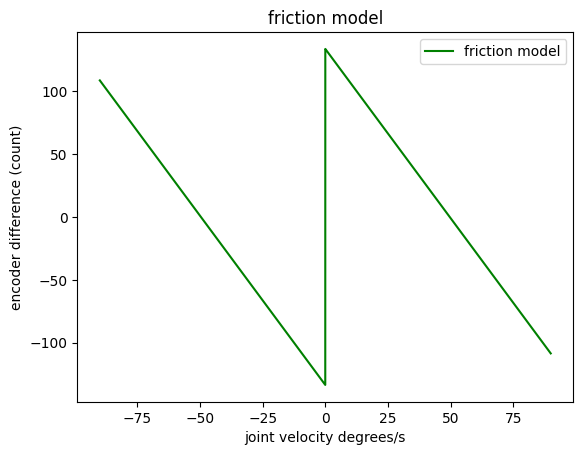

In [9]:
#append all dataframes
dfs = data[sample].iloc[:0,:].copy()
for key in data:
    dfs=pd.concat([dfs,data[key]])

#model friction
parameters,_ = curve_fit(friction_model,dfs.joint_velocity_3*radian_to_deg,dfs.residual_error2)
#save variables to file
np.save("utils/analytical/friction_coeff.npy",parameters)

y = np.arange (-90, 90, 0.01)
x = friction_model(y,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5])
plt.plot(y,x,'g',label='friction model')
plt.legend()
plt.xlabel("joint velocity degrees/s")
plt.ylabel("encoder difference (count)")
plt.title("friction model")
plt.legend()
plt.show()
plt.close()


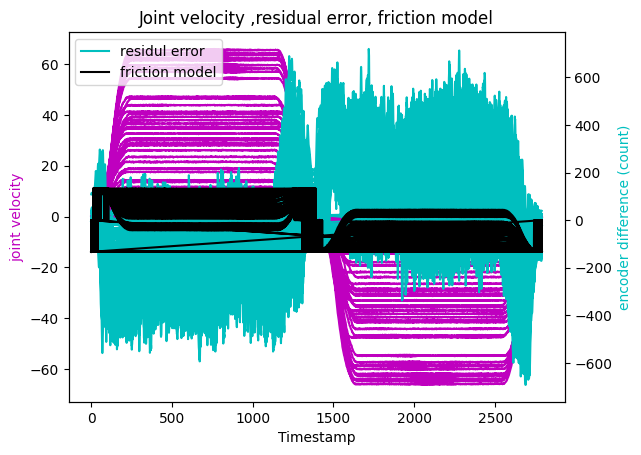

In [10]:


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfs.joint_velocity_3*radian_to_deg,'m',label = " joint velocity")
ax2.plot( dfs.residual_error,'c',label = "residul error")
dfs['modeled_friction'] = dfs.apply(lambda row: friction_model(row["joint_velocity_3"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
ax2.plot(dfs.modeled_friction,'black',label='friction model')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('joint velocity', color='m')
ax2.set_ylabel('encoder difference (count)', color='c')
ax2.legend()
plt.title("Joint velocity ,residual error, friction model")
plt.show()
plt.close()

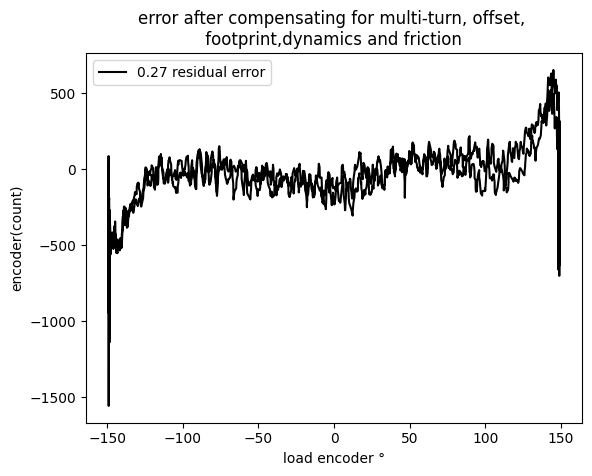

In [11]:
#comepnesate for friction
for key in data:
    data[key]['modeled_friction'] = data[key].apply(lambda row: friction_model(row["filtered_joint_velocity"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
    data[key]["residual_error3"] = data[key].residual_error2 - data[key].modeled_friction
    

plt.plot(data["0.04"].encoder_loadinc_3*count_to_deg, data["0.04"].residual_error3,'black',label = '0.27 residual error')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("error after compensating for multi-turn, offset, \n footprint,dynamics and friction ")
plt.show()
plt.close()


## 3.1.5 External Torque = Residual Torque ?
From the residual torque that remains after compensating for all known components, it is evident that there are unmodeled torques or inaccuracies in the existing torque models. This residual torque, as per our hypothesis, represents the unaccounted external forces acting on the system. However, the presence of residuals suggests that the current models do not fully capture all dynamic effects. This observation motivates the next chapter, where machine learning techniques are employed to learn and model these residual torques, aiming to improve the accuracy and reliability of torque estimation in the robotic system.

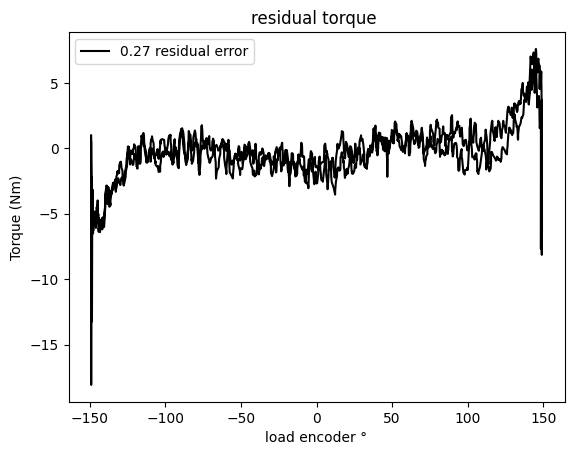

In [12]:
#comepnesate for friction
for key in data:
    data[key]['torque_estimate'] = data[key].apply(lambda row: encoder_error_to_torque(row["residual_error3"]),axis=1)
plt.plot(data["0.04"].encoder_loadinc_3*count_to_deg, data["0.04"].torque_estimate,'black',label = '0.27 residual error')
plt.ylabel('Torque (Nm)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("residual torque ")
plt.show()
plt.close()    